<!--NOTEBOOK_HEADER-->
*This notebook contains material from [ND-Pyomo-Cookbook](https://jckantor.github.io/ND-Pyomo-Cookbook);
content is available [on Github](https://github.com/jckantor/ND-Pyomo-Cookbook.git).*
*The text is released under the [CC-BY-NC-ND-4.0 license](https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode),
and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

<!--NAVIGATION-->
< [2.6 Model Predictive Control of a Double Integrator](https://jckantor.github.io/ND-Pyomo-Cookbook/02.06-Model-Predictive-Control-of-a-Double-Integrator.html) | [Contents](toc.html) | [Tag Index](tag_index.html) | [3.0 Assignment Problems](https://jckantor.github.io/ND-Pyomo-Cookbook/03.00-Assignment-Problems.html) ><p><a href="https://colab.research.google.com/github/jckantor/ND-Pyomo-Cookbook/blob/master/docs/02.07-Non-Continuous-Objective.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/ND-Pyomo-Cookbook/02.07-Non-Continuous-Objective.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# 2.7 Non-Continuous Objectives

Keywords: linear programming, cbc usage, production models

This notebook demonstrates the use of linear programming to maximize profit for a simple model of a multiproduct production facility. The notebook uses [Pyomo](http://www.pyomo.org/) to represent the model with the [COINOR-CBC](https://github.com/coin-or/Cbc) solver to calculate solutions.

## 2.7.1 Imports

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("cbc") or os.path.isfile("cbc")):
    if "google.colab" in sys.modules:
        !apt-get install -y -qq coinor-cbc
    else:
        try:
            !conda install -c conda-forge coincbc 
        except:
            pass

assert(shutil.which("cbc") or os.path.isfile("cbc"))

from pyomo.environ import *

## 2.7.2 Example: Production Bonuses

A plant produces three products in the amounts $x$, $y$, and $z$ with unit profit of \\$40, \\$30, and \\$50, respectively. There are several constraints imposed by product demand and the availability of specialized labor

\begin{align*}
x & \leq 40 \\
x + y & \leq 80 \\
2x + z & \leq 100 \\
z & \leq 50
\end{align*}

In addition, the plant receives bonuses for meeting certain production targets

* If the plant produces more than 20 $y$ items, then the unit profit for $y$ will be \\$50 plus a fixed bonus of \\$200.
* If the plant produces more than 30 $z$ items, then the unit profit for $z$ will be \\$60 plus a fixed bonus of \\$300.

Find the optimal production targets.

## 2.7.3 Model 1. Without bonuses

In [ ]:
from pyomo.environ import *

model = ConcreteModel()
model.x = Var(domain=NonNegativeReals)
model.y = Var(domain=NonNegativeReals)
model.z = Var(domain=NonNegativeReals)

model.profit = Objective(expr = 40*model.x + 30*model.y + 50*model.z, sense=maximize)
model.demand = Constraint(expr = model.x <= 40)
model.laborA = Constraint(expr = model.x + model.y <= 80)
model.laborB = Constraint(expr = 2*model.x + model.z <= 100)
model.laborC = Constraint(expr = model.z <= 50)

# solve
SolverFactory('cbc').solve(model).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -5150.0
  Upper bound: -5150.0
  Number of objectives: 1
  Number of constraints: 5
  Number of variables: 4
  Number of nonzeros: 2
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.0
  Wallclock time: 0.0
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: None
      Number of created

The results of the solution step show the solver has converged to an optimal solution. Next we display the particular components of the model of interest to us.

In [ ]:
print(f"Profit = ${model.profit()}")
print(f"X = {model.x()} units")
print(f"Y = {model.y()} units")
print(f"Z = {model.z()} units")

Profit = $5150.0
X = 25.0 units
Y = 55.0 units
Z = 50.0 units


## 2.7.4 Model 2. Include bonuses

To incorporate the bonus structure into the objective function, we introduce new decision variables

\begin{align*}
y & = y_0 + y_1 \\
z & = z_0 + z_1 \\
\end{align*}

where $y$ and $z$ denote total production, and $y_1$ and $z_1$ denote production above bonus levels. In addition, we introduce two binary variables, $b_y$ and $b_z$, to indicate when $y$ or $z$, respectively, are in a bonus condition. 

The profit objective becomes (after some arithmetic)

$$ P = 40x + 30y_0 + 50y_1 + 600 b_y + 50z_0 + 60 z_1 + 600 b_z $$

For a sufficiently large value of $M$, the constraints

\begin{align*}
y_1 & \leq M b_y \\
z_1 & \leq M b_z \\
\end{align*}

\begin{align*}
y_0 & \leq 20 \\
y_0 & \geq 20 - M(1-b_y)
\end{align*}

\begin{align*}
z_0 & \leq 30 \\
z_0 & \geq 30 - M(1-b_z)
\end{align*}

enforce the bonus conditions.

Let's verify this formulation and new objective before proceeding further.

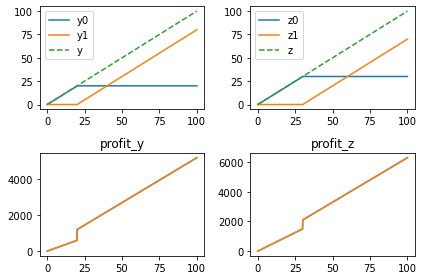

In [ ]:
y = np.linspace(0, 100, 1000)
profit_y = [30*_ if _ <= 20 else (50*_ + 200) for _ in y]

y0 = np.array([min(20, _) for _ in y])
y1 = y - y0
by = np.array([1 if _ > 0 else 0 for _ in y1])
bonus_y  = 30*y0 + 50*y1 + 600*by

fig, ax = plt.subplots(2, 2)

ax[0,0].plot(y, y0, label='y0')
ax[0,0].plot(y, y1, label='y1')
ax[0,0].plot(y, y0 + y1, '--', label='y')
ax[0,0].legend()

ax[1,0].plot(y, profit_y)
ax[1,0].plot(y, bonus_y)
ax[1,0].set_title("profit_y")

z = np.linspace(0, 100, 1000)
profit_z = [50*_ if _ <= 30 else (60*_ + 300) for _ in z]

z0 = np.array([min(30, _) for _ in z])
z1 = z - z0
bz = np.array([1 if _ > 0 else 0 for _ in z1])
bonus_z = 50*z0 + 60*z1 + 600*bz

ax[0,1].plot(z, z0, label='z0')
ax[0,1].plot(z, z1, label='z1')
ax[0,1].plot(z, z0 + z1, '--', label='z')
ax[0,1].legend()

ax[1,1].plot(y, profit_z)
ax[1,1].plot(y, bonus_z)
ax[1,1].set_title("profit_z")

fig.tight_layout()

The corresponding Pyomo model follows. Note that this could be streamlined in various ways.

In [22]:
from pyomo.environ import *

M = 100

model = ConcreteModel()

model.x = Var(domain=NonNegativeReals)

model.y = Var(domain=NonNegativeReals)
model.y0 = Var(bounds=(0, 20))
model.y1 = Var(domain=NonNegativeReals)
model.by = Var(domain=Binary)

model.z = Var(domain=NonNegativeReals)
model.z0 = Var(bounds=(0, 30))
model.z1 = Var(domain=NonNegativeReals)
model.bz = Var(domain=Binary)

model.profit = Objective(sense=maximize, expr = 
                         + 40*model.x \
                         + 30*model.y0 + 50*model.y1 + 600*model.by \
                         + 50*model.z0 + 60*model.z1 + 600*model.bz)

model.dy = Constraint(expr = model.y == model.y0 + model.y1)
model.dz = Constraint(expr = model.z == model.z0 + model.z1)

model.demand = Constraint(expr = model.x <= 40)
model.laborA = Constraint(expr = model.x + model.y <= 80)
model.laborB = Constraint(expr = 2*model.x + model.z <= 100)
model.laborC = Constraint(expr = model.z <= 50)

model.bonus_y0 = Constraint(expr = model.y0 >= 20 - M*(1 - model.by))
model.bonus_z0 = Constraint(expr = model.z0 >= 30 - M*(1 - model.bz))
model.bonus_y1 = Constraint(expr = model.y1 <= M*model.by)
model.bonus_z1 = Constraint(expr = model.z1 <= M*model.bz)

# solve
SolverFactory('cbc').solve(model).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -7500.0
  Upper bound: -7500.0
  Number of objectives: 1
  Number of constraints: 7
  Number of variables: 8
  Number of binary variables: 2
  Number of integer variables: 2
  Number of nonzeros: 7
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.05
  Wallclock time: 0.06
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound:

In [19]:
print(f"Profit = ${model.profit()}")
print(f"X = {model.x()} units")
print(f"Y = {model.y0()} + {model.y1()} = {model.y()} units  {model.by()}")
print(f"Z = {model.z0()} + {model.z1()} = {model.z()} units  {model.bz()}")

Profit = $7500.0
X = 0.0 units
Y = 20.0 + 60.0 = 80.0 units  1.0
Z = 30.0 + 20.0 = 50.0 units  1.0


## 2.7.5 Comments

This particular formulation leaves much to be desired. 

* The main thing is a lack of numerical robustness on the constraints for $z_0$ and $y_0$. * * It would also be useful to parameterize and general the bonus structure.
* The big M method often yields redundant constraints and numerical performance that depends on the choice of M. Generalized disjunctive constraints provide more solution options.

## 2.7.6 Exercise

Reformulate this model using the Pyomo.GDP package. Parameterize values for the profit objective, bonus amounts, and bonus levels.

<!--NAVIGATION-->
< [2.6 Model Predictive Control of a Double Integrator](https://jckantor.github.io/ND-Pyomo-Cookbook/02.06-Model-Predictive-Control-of-a-Double-Integrator.html) | [Contents](toc.html) | [Tag Index](tag_index.html) | [3.0 Assignment Problems](https://jckantor.github.io/ND-Pyomo-Cookbook/03.00-Assignment-Problems.html) ><p><a href="https://colab.research.google.com/github/jckantor/ND-Pyomo-Cookbook/blob/master/docs/02.07-Non-Continuous-Objective.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/ND-Pyomo-Cookbook/02.07-Non-Continuous-Objective.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>